In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import glob

##### Define data paths

In [2]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\7_week\\data\\img\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\7_week\\data\\msk\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.6

#length of image and mask folder is the same
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


15


In [ ]:
torch.set_printoptions(profile="full")

##### Custom dataset

In [15]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
#         self.num_classes = num_classes
#         self.transforms = transforms

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        
        ####
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
       # mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


In [16]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 2, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 2, shuffle = False)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[1][1][0])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[1][0][0])
plt.show()
#print(train_data[1][1])
print(train_data[1][0].shape)

In [17]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [19]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) #        
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8)   
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
        
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))
        
        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
        
        x = self.out(x)
        
        return x
  

In [20]:
model = UNet()
model = model.to(device)
#print(model)

In [ ]:
image = torch.rand((1,1,256,256))
out = model(image.to(device))
print(out.shape)
print(image.shape)

In [21]:
learning_rate = 0.0002
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model(image.to(device))

In [34]:
# The training loop
epochs = 500
total_steps = len(train_loader)
#print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_loader):
       
          #images_batch = torch.from_numpy(np.array(images))
#         masks_batch = torch.from_numpy(np.array(masks))
  
        images = images.to(device)
#        masks = masks.type(torch.LongTensor)
#        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        #print(images.shape)
        # Forward pass
        outputs = model(masks)
        
#        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        
        loss = criterion(outputs, images)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")

Epoch [1/500], Step [0/5], Loss: 0.678845
Epoch [2/500], Step [0/5], Loss: 0.709483
Epoch [3/500], Step [0/5], Loss: 0.678158
Epoch [4/500], Step [0/5], Loss: 0.660711
Epoch [5/500], Step [0/5], Loss: 0.695275
Epoch [6/500], Step [0/5], Loss: 0.694230
Epoch [7/500], Step [0/5], Loss: 0.704463
Epoch [8/500], Step [0/5], Loss: 0.674552
Epoch [9/500], Step [0/5], Loss: 0.657538
Epoch [10/500], Step [0/5], Loss: 0.678112
Epoch [11/500], Step [0/5], Loss: 0.667754
Epoch [12/500], Step [0/5], Loss: 0.680302
Epoch [13/500], Step [0/5], Loss: 0.675652
Epoch [14/500], Step [0/5], Loss: 0.673789
Epoch [15/500], Step [0/5], Loss: 0.666608
Epoch [16/500], Step [0/5], Loss: 0.700481
Epoch [17/500], Step [0/5], Loss: 0.674324
Epoch [18/500], Step [0/5], Loss: 0.672647
Epoch [19/500], Step [0/5], Loss: 0.668360
Epoch [20/500], Step [0/5], Loss: 0.667732
Epoch [21/500], Step [0/5], Loss: 0.703736
Epoch [22/500], Step [0/5], Loss: 0.676306
Epoch [23/500], Step [0/5], Loss: 0.663410
Epoch [24/500], Step

Epoch [190/500], Step [0/5], Loss: 0.674096
Epoch [191/500], Step [0/5], Loss: 0.664372
Epoch [192/500], Step [0/5], Loss: 0.682890
Epoch [193/500], Step [0/5], Loss: 0.650037
Epoch [194/500], Step [0/5], Loss: 0.650999
Epoch [195/500], Step [0/5], Loss: 0.649776
Epoch [196/500], Step [0/5], Loss: 0.657186
Epoch [197/500], Step [0/5], Loss: 0.669210
Epoch [198/500], Step [0/5], Loss: 0.657893
Epoch [199/500], Step [0/5], Loss: 0.677015
Epoch [200/500], Step [0/5], Loss: 0.666068
Epoch [201/500], Step [0/5], Loss: 0.675539
Epoch [202/500], Step [0/5], Loss: 0.681404
Epoch [203/500], Step [0/5], Loss: 0.664132
Epoch [204/500], Step [0/5], Loss: 0.660673
Epoch [205/500], Step [0/5], Loss: 0.690518
Epoch [206/500], Step [0/5], Loss: 0.664144
Epoch [207/500], Step [0/5], Loss: 0.681627
Epoch [208/500], Step [0/5], Loss: 0.657367
Epoch [209/500], Step [0/5], Loss: 0.646292
Epoch [210/500], Step [0/5], Loss: 0.654869
Epoch [211/500], Step [0/5], Loss: 0.660590
Epoch [212/500], Step [0/5], Los

Epoch [377/500], Step [0/5], Loss: 0.614870
Epoch [378/500], Step [0/5], Loss: 0.632846
Epoch [379/500], Step [0/5], Loss: 0.641635
Epoch [380/500], Step [0/5], Loss: 0.648719
Epoch [381/500], Step [0/5], Loss: 0.653204
Epoch [382/500], Step [0/5], Loss: 0.642876
Epoch [383/500], Step [0/5], Loss: 0.612694
Epoch [384/500], Step [0/5], Loss: 0.649916
Epoch [385/500], Step [0/5], Loss: 0.631574
Epoch [386/500], Step [0/5], Loss: 0.662947
Epoch [387/500], Step [0/5], Loss: 0.645372
Epoch [388/500], Step [0/5], Loss: 0.637882
Epoch [389/500], Step [0/5], Loss: 0.610954
Epoch [390/500], Step [0/5], Loss: 0.626799
Epoch [391/500], Step [0/5], Loss: 0.644952
Epoch [392/500], Step [0/5], Loss: 0.647759
Epoch [393/500], Step [0/5], Loss: 0.646353
Epoch [394/500], Step [0/5], Loss: 0.612920
Epoch [395/500], Step [0/5], Loss: 0.660480
Epoch [396/500], Step [0/5], Loss: 0.638126
Epoch [397/500], Step [0/5], Loss: 0.630349
Epoch [398/500], Step [0/5], Loss: 0.649541
Epoch [399/500], Step [0/5], Los

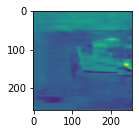

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.squeeze(outputs[0].cpu().detach().numpy()))
plt.show()

image shape: torch.Size([2, 1, 256, 256])
output shape: torch.Size([2, 1, 256, 256])


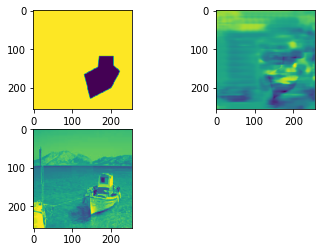

image shape: torch.Size([2, 1, 256, 256])
output shape: torch.Size([2, 1, 256, 256])


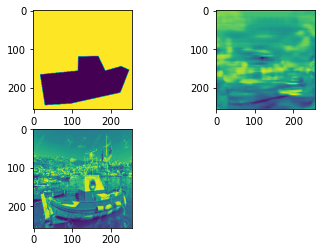

image shape: torch.Size([2, 1, 256, 256])
output shape: torch.Size([2, 1, 256, 256])


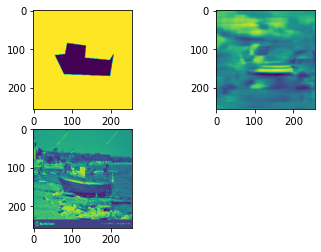

In [36]:
for i, (images, masks) in enumerate(test_loader):
    masks = masks.to(device)
    output = model(masks)
    
    print("image shape:", masks.shape)
    print("output shape:", output.shape)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()))
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()))
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()))
    
    plt.show()


In [ ]:
image = Image.open('test_textures/boat.jpg')
img = image.resize((300,300))
img = img.convert('L')
display(img)
print(img)
print(img.size)

#connvert to tensor
trans1 = transforms.ToTensor()
img = trans1(img).view(1,1,300,300)
print(img.shape)

In [ ]:
image = torch.rand((1,1,300,300))

In [ ]:
outputs = model(img.to(device))
img1 = np.squeeze(outputs[0].cpu().detach().numpy())
print(img1.shape)
plt.imshow(img1)
plt.show()


In [ ]:
img3 = np.squeeze(myImage.detach().numpy())
img3 = (img3)
print(img3.shape)
plt.imshow(img3)
plt.show()